<a href="https://colab.research.google.com/github/Usually-zz/2021_IMC/blob/main/no_filtered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import seaborn as sns

%matplotlib inline

In [2]:
def compute_p_y_given_z(Y, Theta):
  """ Returns NxC
  p(y_n | z_n = c)
  """
  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma']) + 1e-6

  dist_Y = D.Normal(mu, sigma)
  return dist_Y.log_prob(Y.reshape(no, 1, nf)).sum(2) # <- sum because IID over G

def compute_p_s_given_z(S, Theta):
  """ Returns NxC
  p(s_n | z_n = c)
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  dist_S = D.Normal(psi, omega)
  return dist_S.log_prob(S.reshape(-1,1)) 

def compute_p_y_given_gamma(Y, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """

  mu = torch.exp(Theta['log_mu'])
  sigma = torch.exp(Theta['log_sigma'])  + 1e-6

  mu2 = mu.reshape(1, nc, nf)
  mu2 = (mu2 + mu2.permute(1, 0, 2)) / 2.0 # C x C x G matrix 

  sigma2 = sigma.reshape(1, nc, nf)
  sigma2 = (sigma2 + sigma2.permute(1,0,2)) / 2.0

  dist_Y2 = D.Normal(mu2, sigma2)
  return  dist_Y2.log_prob(Y.reshape(-1, 1, 1, nf)).sum(3) # <- sum because IID over G

def compute_p_s_given_gamma(S, Theta):
  """ NxCxC
  p(y_n | gamma_n = [c,c'])
  """
  psi = torch.exp(Theta['log_psi'])
  omega = torch.exp(Theta['log_omega'])  + 1e-6

  psi2 = psi.reshape(-1,1)
  psi2 = psi2 + psi2.T

  omega2 = omega.reshape(-1,1)
  omega2 = omega2 + omega2.T

  dist_S2 = D.Normal(psi2, omega2)
  return dist_S2.log_prob(S.reshape(-1, 1, 1))

def compute_r_v_2(Y, S, Theta):
  """Need to compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(no, -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  p_data = torch.logsumexp(p_data, dim=1)

  r = p_data_given_z_d0.T + log_delta[0] - p_data
  v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  return r.T, v.T.reshape(-1,nc,nc), p_data, p_singlet

In [3]:
def Q(Theta, Y, S, r, v, ignored_indices):

  log_pi = F.log_softmax(Theta['is_pi'])
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1)).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'])

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  log_rd0z = p_s_given_z + p_y_given_z + log_pi + log_delta[0]

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  log_rd1g = p_y_given_gamma + p_s_given_gamma + log_tau + log_delta[1]


  q1 = log_rd0z * r.exp()
  q2 = log_rd1g * v.exp()

  return q1.sum() + q2.sum()

In [4]:
%pip install scanpy

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/')

import scanpy as sc
adata = sc.read_h5ad("basel_zuri_subsample.h5ad")
adata = adata[adata.obs.Area > 50,:]

cell_sel = np.random.choice(adata.shape[0], size=1000)
adata = adata[cell_sel,:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
YY = adata.X
SS = adata.obs.Area

nc = 15 # number of clusters?
nf = YY.shape[1]
no = YY.shape[0]

YY = np.arcsinh(YY / 5.)

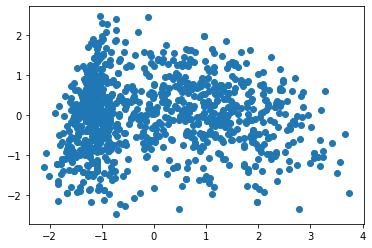

In [7]:
pca = PCA(n_components=2)
Z = pca.fit_transform(YY)

plt.scatter(Z[:,0], Z[:,1]);

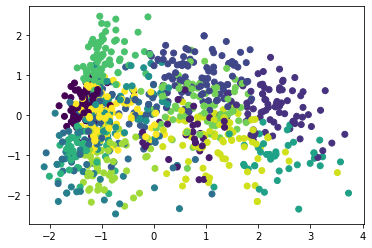

In [8]:
N_INIT = 10

kms = [KMeans(nc).fit(YY) for i in range(N_INIT)]
inertias = [k.inertia_ for k in kms]
km = kms[np.argmin(np.array(inertias))]
init_labels = km.labels_

plt.scatter(Z[:,0], Z[:,1], c=init_labels);

In [9]:
inertias

[2083.6135274645944,
 2075.037451104287,
 2087.3370139551503,
 2065.3625772487494,
 2079.651672511577,
 2076.4529816773083,
 2068.1433925376004,
 2073.9259613886325,
 2074.6402572793177,
 2068.3360842135908]

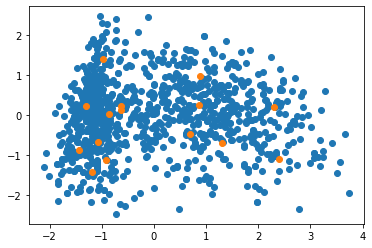

In [10]:
mu_init = np.array([YY[init_labels == i,:].mean(0) for i in np.unique(init_labels)])
sigma_init = np.array([YY[init_labels == i,:].std(0) for i in np.unique(init_labels)])

psi_init = np.array([SS[init_labels == i].mean() for i in np.unique(init_labels)])
omega_init = np.array([SS[init_labels == i].std() for i in np.unique(init_labels)])
pi_init = np.array([np.mean(init_labels == i) for i in np.unique(init_labels)])
tau_init = np.ones((nc,nc))
tau_init = tau_init / tau_init.sum()

Z_mu_init = pca.transform(mu_init)

plt.scatter(Z[:,0], Z[:,1]);
plt.scatter(Z_mu_init[:,0], Z_mu_init[:,1]);

In [11]:
## Very slightly corrupted theta:
Theta = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

Theta = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta.items()}
#Theta['is_delta'].requires_grad = False
#Theta['is_tau'].requires_grad = False
#Theta['log_psi'].requires_grad = False

In [12]:
Theta['log_psi'].exp()

tensor([102.3026, 144.2121, 114.9750, 112.1188,  76.7778, 123.3714, 140.5938,
        100.0154, 119.6667,  88.3750,  74.9773,  99.4074, 113.8028,  98.8659,
         88.3391], dtype=torch.float64, grad_fn=<ExpBackward>)

In [13]:
N_ITER = 1000
N_ITER_OPT = 100
lr = 1e-3
tol = 1e-2

Y = torch.tensor(YY)
S = torch.tensor(SS)

In [14]:
opt = optim.Adam(Theta.values())

ls = []
qs = []
for i in range(N_ITER):

  print(i)

  # E Step:
  with torch.no_grad():
    r, v, L, p_singlet_em = compute_r_v_2(Y, S, Theta)

  # M step (i.e. maximizing Q):
  for j in range(N_ITER_OPT):

    opt.zero_grad()
    q = -Q(Theta, Y, S, r, v, None)
    # print(q)
    q.backward()
    opt.step()
    
  if i % (10 - 1) == 0:
    print("L: {}; {}; {}".format(L.sum(), F.log_softmax(Theta['is_delta'], 0).exp(), F.log_softmax(Theta['is_pi'], 0).exp()))

  # Check for convergence
  if i > 0 and abs(ls[-1] - L.sum()) < tol:
    break

  qs.append(-q.sum())
  ls.append(L.sum())

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to 

L: 102353.08251251368; tensor([0.9398, 0.0602], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0850, 0.0349, 0.0894, 0.1123, 0.0499, 0.0323, 0.0337, 0.0616, 0.0362,
        0.0444, 0.0980, 0.0746, 0.0659, 0.0756, 0.1062], dtype=torch.float64,
       grad_fn=<ExpBackward>)
1
2
3
4
5
6
7
8
9
L: 112666.80166771525; tensor([0.6224, 0.3776], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.1725, 0.0336, 0.1461, 0.1187, 0.0408, 0.0254, 0.0202, 0.0315, 0.0213,
        0.0327, 0.1599, 0.0481, 0.0403, 0.0426, 0.0662], dtype=torch.float64,
       grad_fn=<ExpBackward>)
10
11
12
13
14
15
16
17
18
L: 115947.61293562147; tensor([0.3010, 0.6990], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.2073, 0.0166, 0.1177, 0.1169, 0.0652, 0.0250, 0.0220, 0.0243, 0.0223,
        0.0523, 0.1334, 0.0525, 0.0509, 0.0354, 0.0580], dtype=torch.float64,
       grad_fn=<ExpBackward>)
19
20
21
22
23
24
25
26
27
L: 117012.25085543988; tensor([0.1884, 0.8116], dtype=torch.float64, grad_fn=<ExpBack

In [15]:
F.log_softmax(torch.tensor(Theta['is_delta']), 0).exp()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([0.0816, 0.9184], dtype=torch.float64)

In [16]:
with torch.no_grad():
  r, v, L, p_singlet_em = compute_r_v_2(Y,S,Theta)

p_singlet_em = p_singlet_em.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
#adata.obs

In [18]:
adata.obs['p_singlet_em'] = p_singlet_em
adata.obs['probability_single_cell_em'] = adata.obs.p_singlet_em

Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


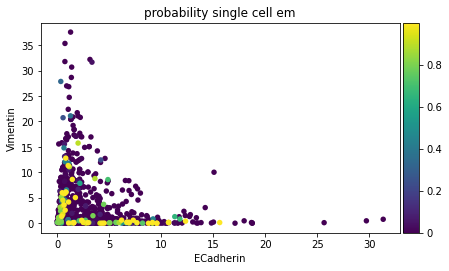

In [19]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_single_cell_em')

In [20]:
p_doublet_em = 1 - p_singlet_em
adata.obs['p_doublet_em'] = p_doublet_em
adata.obs['probability_doublet_cell_em'] = adata.obs.p_doublet_em

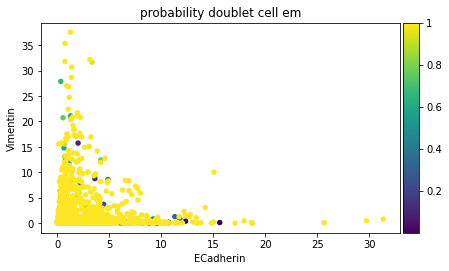

In [21]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_doublet_cell_em')

Text(0, 0.5, 'cell size')

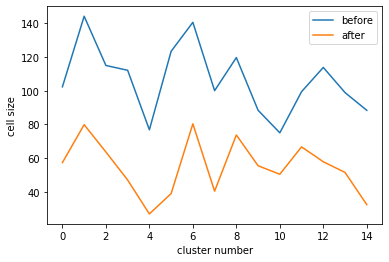

In [22]:
plt.plot(torch.tensor(psi_init), label="before")
plt.plot(Theta['log_psi'].exp().detach().numpy(), label="after")
plt.legend()
plt.xlabel("cluster number")
plt.ylabel("cell size")

Text(0, 0.5, 'll')

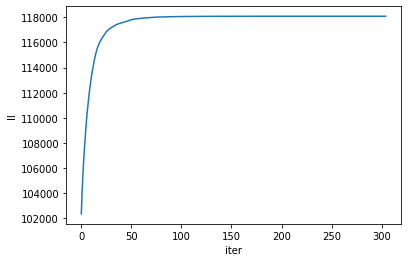

In [23]:
plt.plot(ls)
plt.xlabel("iter")
plt.ylabel("ll")

In [24]:
def ll(Y, S, Theta):
  """compute
  p(gamma = [c,c'], d= 1 | Y,S)
  p(z = c, d=0 | Y,S)
  """
  log_pi = F.log_softmax(Theta['is_pi'], 0)
  log_tau = F.log_softmax(Theta['is_tau'].reshape(-1), 0).reshape(nc,nc)
  log_delta = F.log_softmax(Theta['is_delta'], 0)

  p_y_given_z = compute_p_y_given_z(Y, Theta)
  p_s_given_z = compute_p_s_given_z(S, Theta)

  p_data_given_z_d0 = p_y_given_z + p_s_given_z + log_pi
  p_data_given_d0 = torch.logsumexp(p_data_given_z_d0, dim=1) # this is p(data|d=0)

  p_y_given_gamma = compute_p_y_given_gamma(Y, Theta)
  p_s_given_gamma = compute_p_s_given_gamma(S, Theta)

  p_data_given_gamma_d1 = (p_y_given_gamma + p_s_given_gamma + log_tau).reshape(Y.shape[0], -1)

  # p_data_given_d1 = torch.logsumexp(p_data_given_gamma_d1, dim=1)

  p_data = torch.cat([p_data_given_z_d0 + log_delta[0], p_data_given_gamma_d1 + log_delta[1]], dim=1)
  #p_data = torch.logsumexp(p_data, dim=1)

  #r = p_data_given_z_d0.T + log_delta[0] - p_data
  #v = p_data_given_gamma_d1.T + log_delta[1] - p_data

  #p_singlet = torch.exp(p_data_given_d0 + log_delta[0] - p_data)

  #return r.T, v.T.reshape(-1,nc,nc), -p_data, p_singlet

  return torch.logsumexp(p_data, dim=1).sum()

In [25]:
## Very slightly corrupted theta:
Theta1 = {
    'log_mu': np.log(mu_init + 1e-6),
    'log_sigma': np.log(sigma_init + 1e-6), #np.zeros_like(sigma_init),
    'log_psi': np.log(psi_init + 1e-6),
    'log_omega': np.log(omega_init + 1e-6),
    "is_delta": np.log([0.95, 1-0.95]),
    'is_pi': np.log(pi_init),
    'is_tau': np.log(tau_init)
}

Theta1 = {k: torch.tensor(v, requires_grad=True) for (k,v) in Theta1.items()}
#Theta1['is_delta'].requires_grad = False
#Theta1['is_tau'].requires_grad = False
#Theta1['log_psi'].requires_grad = False

In [26]:
opt = optim.Adam(Theta1.values())

loss = []
for epoch in range(N_ITER * N_ITER_OPT):

  #print(i)

  opt.zero_grad()
  nlls = -ll(Y, S, Theta1) #nll
  nlls.backward()
  opt.step()

  if epoch % (100 - 1) == 0:
    print("L: {}; {}; {}".format(nlls, F.log_softmax(Theta1['is_delta'], 0).exp(), F.log_softmax(Theta1['is_pi'], 0).exp()))
      
  if epoch > 0 and abs(loss[-1] - nlls) < tol:
    break
  
  loss.append(nlls)

L: -102353.08251251368; tensor([0.9499, 0.0501], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0761, 0.0330, 0.0801, 0.1011, 0.0540, 0.0350, 0.0320, 0.0649, 0.0390,
        0.0480, 0.0881, 0.0809, 0.0709, 0.0819, 0.1149], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -104682.48812802607; tensor([0.9387, 0.0613], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0862, 0.0353, 0.0904, 0.1130, 0.0500, 0.0325, 0.0303, 0.0596, 0.0358,
        0.0444, 0.0990, 0.0754, 0.0657, 0.0759, 0.1065], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -106403.21764391685; tensor([0.9228, 0.0772], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.0976, 0.0345, 0.1021, 0.1205, 0.0464, 0.0307, 0.0275, 0.0535, 0.0333,
        0.0420, 0.1094, 0.0710, 0.0614, 0.0700, 0.1002], dtype=torch.float64,
       grad_fn=<ExpBackward>)
L: -107848.107983748; tensor([0.9023, 0.0977], dtype=torch.float64, grad_fn=<ExpBackward>); tensor([0.1091, 0.0358, 0.1132, 0.1234, 0.0433, 0.0293, 0.0254

In [27]:
F.log_softmax(Theta1['is_delta'], 0).exp()

tensor([0.0980, 0.9020], dtype=torch.float64, grad_fn=<ExpBackward>)

In [28]:
with torch.no_grad():
  r, v, L, p_singlet_mle = compute_r_v_2(Y,S,Theta1)

p_singlet_mle = p_singlet_mle.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


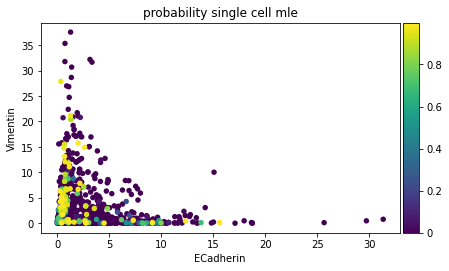

In [29]:
adata.obs['p_singlet_mle'] = p_singlet_mle
adata.obs['probability_single_cell_mle'] = adata.obs.p_singlet_mle
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_single_cell_mle')

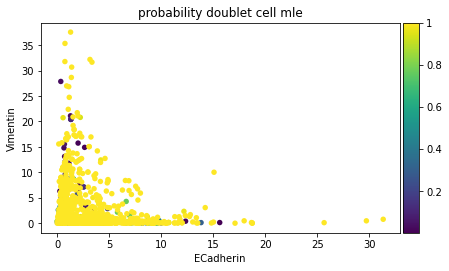

In [30]:
p_doublet_mle = 1 - p_singlet_mle
adata.obs['p_doublet_mle'] = p_doublet_mle
adata.obs['probability_doublet_cell_mle'] = adata.obs.p_doublet_mle
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'probability_doublet_cell_mle')

Text(0, 0.5, 'cell size')

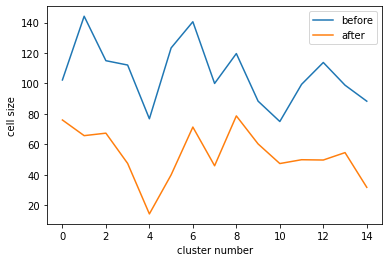

In [31]:
plt.plot(torch.tensor(psi_init), label="before")
plt.plot(Theta1['log_psi'].exp().detach().numpy(), label="after")
plt.legend()
plt.xlabel("cluster number")
plt.ylabel("cell size")

Text(0, 0.5, 'nll')

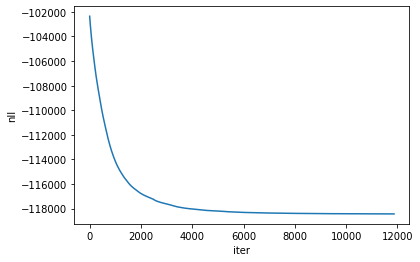

In [32]:
plt.plot(loss)
plt.xlabel("iter")
plt.ylabel("nll")

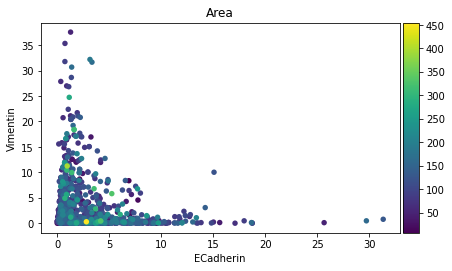

In [33]:
sc.pl.scatter(adata, x = 'ECadherin', y = 'Vimentin', color = 'Area')

Text(0, 0.5, 'Count')

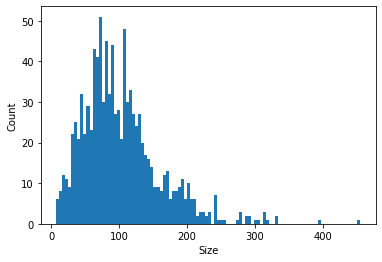

In [34]:
plt.hist(adata.obs['Area'], bins = 100)
plt.xlabel("Size")
plt.ylabel("Count")